In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy
import math
import random
import sklearn
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import timeit
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
start_time = datetime.now()

In [2]:
class RestrictedBoltzmannMachine():
    """
    Python implementation of a Restricted Boltzmann Machine (RBM) with 'c_nh' hidden nodes and 'c_nv' visible nodes.
    """
    def __init__(self, c_nv, c_nh):
        """
        RBM initialization module where three tensors are defined:
        W - Weight tensor
        a - Visible node bias tensor
        b - Hidden node bias tensor
        a and b are created as two-dimensional tensors to accommodate batches of observations over training.
        """
        self.W = torch.randn(c_nh, c_nv)
        self.a = torch.randn(1, c_nh)
        self.b = torch.randn(1, c_nv)

        
    def sample_h(self, c_vx):
        """
        Method devoted to Gibbs sampling probabilities of hidden nodes given visible nodes - p (h|v)
        c_vx - Input visible node tensor
        """
        c_w_vx = torch.mm(c_vx, self.W.t())
        c_activation = c_w_vx + self.a.expand_as(c_w_vx)
        c_p_h_given_v = torch.sigmoid(c_activation)
        return c_p_h_given_v, torch.bernoulli(c_p_h_given_v)

    
    def sample_v(self, c_hx):
        """
        Method devoted to Gibbs sampling probabilities of visible nodes given hidden nodes - p (v|h)
        c_hx - Input hidden node tensor
        """
        c_w_hx = torch.mm(c_hx, self.W)
        c_activation = c_w_hx + self.b.expand_as(c_w_hx)
        c_p_v_given_h = torch.sigmoid(c_activation)
        return c_p_v_given_h, torch.bernoulli(c_p_v_given_h)

    
    def train(self, c_nr_observations, c_nr_epoch, c_batch_size, c_train_tensor, c_metric):
        """
        Method through which contrastive divergence-based training is performed.
        c_nr_observations - Number of observations used for training
        c_nr_epoch - Number of training epochs
        c_batch_size - Batch size
        c_train_tensor - Tensor containing training observations
        c_metric - Training performance metric of choice ('MAbsE' for Mean Absolute Error, 'RMSE' for Root Mean Square Error)
        """
        print('Training...')
        for c_epoch in range(1, c_nr_epoch + 1):
            c_start_time = datetime.now()
            print(f'Epoch {str(c_epoch)} of {str(c_nr_epoch)} ', end='')
            c_train_loss = 0
            c_s = 0.
            for c_id_user in range(0, c_nr_observations - c_batch_size, c_batch_size):
                c_v0 = c_train_tensor[c_id_user:c_id_user+c_batch_size]
                c_vk = c_train_tensor[c_id_user:c_id_user+c_batch_size]
                c_ph0,_ = self.sample_h(c_v0)
                for c_k in range(10):
                    _,c_hk = self.sample_h(c_vk)
                    _,c_vk = self.sample_v(c_hk)
                    c_vk[c_v0<0] = c_v0[c_v0<0]
                c_phk,_ = self.sample_h(c_vk)
                self.W += (torch.mm(c_v0.t(), c_ph0) - torch.mm(c_vk.t(), c_phk)).t()
                self.b += torch.sum((c_v0 - c_vk), 0)
                self.a += torch.sum((c_ph0 - c_phk), 0)
                if c_metric == 'MAbsE':
                    c_train_loss += torch.mean(torch.abs(c_v0[c_v0>=0] - c_vk[c_v0>=0]))
                elif c_metric == 'RMSE':
                    c_train_loss += np.sqrt(torch.mean((c_v0[c_v0>=0] - c_vk[c_v0>=0])**2))
                c_s += 1.
            c_end_time = datetime.now()
            c_time_elapsed = c_end_time - c_start_time
            c_time_elapsed = c_time_elapsed.total_seconds()
            print(f'- Loss ({c_metric}): {c_train_loss/c_s:.8f} ({c_time_elapsed:.2f} seconds)')


    def test(self, c_nr_observations, c_train_tensor, c_test_tensor, c_metric):
        """
        Method through which testing is performed.
        c_nr_observations - Number of observations used for testing
        c_train_tensor - Tensor containing training observations
        c_test_tensor - Tensor containing testing observations
        c_metric - Training performance metric of choice ('MAbsE' for Mean Absolute Error, 'RMSE' for Root Mean Square Error)
        """
        print('Testing...')
        c_test_loss = 0
        c_s = 0.
        for c_id_user in range(c_nr_observations):
            c_v = c_train_tensor[c_id_user:c_id_user+1]
            c_vt = c_test_tensor[c_id_user:c_id_user+1]
            if len(c_vt[c_vt>=0]) > 0:
                _,c_h = self.sample_h(c_v)
                _,c_v = self.sample_v(c_h)
                if c_metric == 'MAbsE':
                    c_test_loss += torch.mean(torch.abs(c_vt[c_vt>=0] - c_v[c_vt>=0]))
                elif c_metric == 'RMSE':
                    c_test_loss += np.sqrt(torch.mean((c_vt[c_vt>=0] - c_v[c_vt>=0])**2))
                c_s += 1.
        print(f'Test loss ({c_metric}): {c_test_loss/c_s:.8f}')
        
        
    def predict(self, c_visible_nodes):
        """
        Method through which predictions for one specific observation are derived.
        c_visible_nodes - Tensor containing one particular observation (set of values for each visible node) 
        """
        c_h_v,_ = self.sample_h(c_visible_nodes)
        c_v_h,_ = self.sample_v(c_h_v)
        return c_v_h

In [3]:
def convert(f_data, f_nr_observations, f_nr_entities):
        """
        Generates (from a numpy array) a list of lists containing the number of hits per user (rows), per entity (columns).
        Each of the constituent lists will correspond to an observation / user (row).
        Each observation list will contain the number of hits (columns), one for each hit entity
        f_data - Input table (numpy array)
        f_nr_observations - Number of observations
        f_nr_entities - Number of entities hit in each observation
        """
        f_converted_data = []
        for f_id_user in range(1, f_nr_observations + 1):
            f_id_entity = f_data[:,1][f_data[:,0] == f_id_user].astype(int)
            f_id_hits = f_data[:,2][f_data[:,0] == f_id_user]
            f_hits = np.zeros(f_nr_entities)
            f_hits[f_id_entity - 1] = f_id_hits
            f_converted_data.append(list(f_hits))
        return f_converted_data

In [4]:
def evaluation(future_recommendations, train_df, test_df, time=0, k=5, results = [], algo=''):
    """
    Evaluates performance of models
    future_recommendations - recommendations (pandas dataframe)
    train_df - training data (pandas dataframe)
    test_df - test data (pandas dataframe)
    time - time spend on prediction
    k - number of recommendation per user
    results - all performances (list)
    algo - name of the algorithm
    """
    evaluation = test_df.merge(future_recommendations[['SUB_ID_index','A_TITLE_ID_index','preds']],
                               on =['SUB_ID_index','A_TITLE_ID_index'], how = 'left')
    precision = len(evaluation[~evaluation.preds.isna()]) / (len(test_df.SUB_ID_index.unique())*k)
    recall = len(evaluation[~evaluation.preds.isna()]) / len(test_df)
    f1_score = 2*recall*precision/(recall + precision)
    
    out = {'algo':algo,'precision':round(precision*100,3),
           'recall':round(recall*100,3),
           'F1_score':round(f1_score*100,3),
            'k':k,
          'time(secs)': time}
    results.append(out)
    return results

In [5]:
def rbm_recommend(f_content,f_user, train_df, test_df, f_model, k=5, results = []):
    """
    restricted boltzmann machine predict
    f_content - unique contents (pandas dataframe)
    f_user - unique users (pandas dataframe)
    train_df - training data (pandas dataframe)
    test_df - test data (pandas dataframe)
    f_model - rbm model
    k - number of recommendation per user
    results - all performances (list)
    """
    #prepare input data
    starttime = timeit.default_timer()
    train_data = train_df[['SUB_ID_index','A_TITLE_ID_index','interaction_level']]
    train_data['interaction_level'] = train_data.groupby('SUB_ID_index')[['interaction_level']].\
    apply(lambda x: (x-x.min())/(x.max()-x.min()))
    train_data['interaction_level'] = train_data['interaction_level'].fillna(0.5)

    test_data = test_df[['SUB_ID_index','A_TITLE_ID_index','interaction_level']]
    test_data['interaction_level'] = test_data.groupby('SUB_ID_index')[['interaction_level']].\
    apply(lambda x: (x-x.min())/(x.max()-x.min()))
    test_data['interaction_level'] = test_data['interaction_level'].fillna(0.5)

    training_set = train_data
    test_set = test_data
    training_set = training_set.values
    test_set = test_set.values

    nr_users = int(max(max(training_set[:,0]), max(test_set[:,0])))+1
    nr_artists = int(max(max(training_set[:,1]), max(test_set[:,1])))+1

    training_set = convert(training_set, nr_users, nr_artists)
    test_set = convert(test_set, nr_users, nr_artists)
    training_set = torch.FloatTensor(training_set)
    test_set = torch.FloatTensor(test_set)

    f_users = test_df.SUB_ID_index.unique()
    f_users = [x - 1 for x in f_users]
    f_user_sample = training_set[f_users]

    f_prediction = f_model.predict(f_user_sample).numpy()
    f_user_sample = f_user_sample.numpy()

    users = pd.DataFrame(f_users, columns = ['SUB_ID_index'])
    users['level_0'] = users.index
    
    #remove watched contents from prediction
    watched_contents = pd.DataFrame(f_user_sample).stack().reset_index()
    watched_contents = watched_contents.merge(users, on = "level_0", how = 'left')
    watched_contents = watched_contents.drop('level_0',axis = 1)
    watched_contents.rename(columns={'level_1':'A_TITLE_ID_index',0:'interaction_level'}, inplace = True)

    watched_contents['A_TITLE_ID_index'] = watched_contents['A_TITLE_ID_index'].apply(lambda x: (x+1)%nr_artists)
    watched_contents['SUB_ID_index'] = watched_contents['SUB_ID_index'].apply(lambda x: (x+1))
    watched_contents['watched'] = 1
    watched_contents = watched_contents[watched_contents.interaction_level>0]

    predictions = pd.DataFrame(f_prediction).stack().reset_index()
    predictions = predictions.merge(users, on = "level_0", how = 'left')
    predictions = predictions.drop('level_0',axis = 1)
    predictions.rename(columns={'level_1':'A_TITLE_ID_index',0:'preds'}, inplace = True)
    predictions['A_TITLE_ID_index'] = predictions['A_TITLE_ID_index'].apply(lambda x: (x+1)%nr_artists)
    predictions['SUB_ID_index'] = predictions['SUB_ID_index'].apply(lambda x: (x+1))
    predictions = predictions.merge(watched_contents, on =['SUB_ID_index','A_TITLE_ID_index'], how = 'left')

    out = predictions.sort_values(by = 'preds', ascending = False).groupby('SUB_ID_index').head(k)
    out = out.merge(f_content, on='A_TITLE_ID_index', how='left')
    out = out.merge(f_user, on='SUB_ID_index', how='left')
    out = out[['SUB_ID_index','A_TITLE_ID_index','preds','A_TITLE_ID','SUB_ID']]

    predictions = predictions[['SUB_ID_index','A_TITLE_ID_index','preds']]
    #print("The time spend for the predictions rbm:", timeit.default_timer() - starttime, 'secs')
    results = evaluation(out, train_df,test_df,time= (timeit.default_timer() - starttime), k=k,
                         results = results,algo='RBM')
    return out,results

In [6]:
#Collaborative model with matrix factorization
def smooth_user_preference(x):
    return math.log(1+x, 2)
def matrix_recommend(train_df,users,contents,  k = 5, results = []):
    """
    svd model predictions
    train_df - training data (pandas dataframe)
    test_df - test data (pandas dataframe)
    contents - unique contents (pandas dataframe
    k - number of recommendation per user
    results - all performances (list)
    """
    starttime = timeit.default_timer()

    interactions_full_df = train_df \
                    .groupby(['SUB_ID_index', 'A_TITLE_ID_index'])['interaction_level'].sum() \
                    .apply(smooth_user_preference).reset_index()
    #print('# of unique user/item interactions: %d' % len(interactions_full_df))
    
    #Creating a sparse pivot table with users in rows and items in columns
    users_items_pivot_matrix_df = interactions_full_df.pivot(index='SUB_ID_index', 
                                                          columns='A_TITLE_ID_index', 
                                                          values='interaction_level').fillna(0)
    users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()
    users_ids = list(users_items_pivot_matrix_df.index)
    users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
    
    #The number of factors to factor the user-item matrix.
    NUMBER_OF_FACTORS_MF = 15
    #Performs matrix factorization of the original user item matrix
    #U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
    U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
    sigma = np.diag(sigma)

    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
    all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())
    cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, 
                               index=users_ids).transpose()

    tmp = cf_preds_df.reset_index()
    predictions = pd.melt(tmp, 
            id_vars='A_TITLE_ID_index', 
            value_vars=list(tmp[1:]), # list of days of the week
            var_name='SUB_ID_index', 
            value_name='preds')
    #top k recommendations
    out = predictions.sort_values(by = 'preds', ascending = False).groupby('SUB_ID_index').head(k)
    
    out = out.merge(users[['SUB_ID_index','SUB_ID']], on =['SUB_ID_index'], how = 'left')
    out = out.merge(contents, on =['A_TITLE_ID_index'], how = 'left' )

    results = evaluation(out, train_df,test_df,time= (timeit.default_timer() - starttime), k=k,
                         results = results,algo='svd')
    
    return out,results

In [7]:
def popular_recommend(train_df,test_df, users, contents, k = 5, results = []):
    """
    baseline predictions
    train_df - training data (pandas dataframe)
    test_df - test data (pandas dataframe)
    users - unique users (pandas dataframe
    contents - unique contents (pandas dataframe
    k - number of recommendation per user
    results - all performances (list)
    """
    starttime = timeit.default_timer()
    #remove watched items
    watched = train_df[['SUB_ID_index','A_TITLE_ID_index']].drop_duplicates()
    watched['watched'] = 1
    
    user_content = users[['SUB_ID_index']].merge(contents[['A_TITLE_ID_index']], how = 'cross')
    populer_contents = train_df.A_TITLE_ID_index.value_counts().reset_index()
    populer_contents.rename(columns = {'A_TITLE_ID_index': 'popularity', 'index':'A_TITLE_ID_index'},
                            inplace = True)

    user_content = user_content.merge(populer_contents, on =['A_TITLE_ID_index'], how = 'left')
    user_content = user_content.dropna()
    user_content = user_content.merge(watched, on =['SUB_ID_index','A_TITLE_ID_index'], how = 'left')
    
    out = user_content[user_content.watched.isna()].sort_values(by = 'popularity', ascending=False).\
    groupby('SUB_ID_index').head(5)
    out = out.merge(users[['SUB_ID_index','SUB_ID']], on =['SUB_ID_index'], how = 'left')
    out = out.merge(contents, on =['A_TITLE_ID_index'], how = 'left' )
    out.drop(columns = ['watched'], axis = 1, inplace = True)
    out.rename(columns = {'popularity':'preds'}, inplace=True)

    results = evaluation(out, train_df,test_df,time= (timeit.default_timer() - starttime), k=k,
                         results = results,algo='popular')
    return out,results

In [8]:
k=1000
train_df = pd.read_pickle('r_movie_train_df_'+str(k)+'.pkl')
test_df = pd.read_pickle('r_movie_test_df_'+str(k)+'.pkl')
users = pd.read_pickle('r_movie_user_data_'+str(k)+'.pkl')
contents = pd.read_pickle('r_movie_content_data_'+str(k)+'.pkl')
len(train_df),len(test_df),len(users),len(contents)

(4532, 1005, 329, 1229)

In [9]:
rbm_model = torch.load('rbm_model.pkl')

In [10]:
performane = []
for k in [5,10,15,20,30]:
    future_recommendations_rbm, performane= rbm_recommend(contents, users,train_df, test_df, 
                                                          rbm_model, k=k, results = performane)

    future_recommendations_svd, performane = matrix_recommend(train_df,users,contents,  k = k, results=performane)
    
    future_recommendations_baseline, performane = popular_recommend(train_df,test_df, users, contents, k=k, results=performane)
performane_df = pd.DataFrame(performane)
performane_df.sort_values(by=['k','F1_score'], ascending = False)

,algo,precision,recall,F1_score,k,time(secs)
13,svd,2.358,20.697,4.234,30,0.169949
12,RBM,1.304,11.443,2.341,30,1.590756
14,popular,0.726,6.368,1.303,30,0.171481
10,svd,2.619,15.323,4.473,20,0.169015
9,RBM,1.395,8.159,2.382,20,1.547982
11,popular,1.088,6.368,1.859,20,0.168005
7,svd,2.766,12.139,4.506,15,0.168415
8,popular,1.451,6.368,2.364,15,0.171282
6,RBM,1.383,6.070,2.253,15,1.554711
4,svd,2.823,8.259,4.208,10,0.174127


 We can see that for small number of guesses popular model "wisdom of the crowds" beates svd and rbm models.
 People watch popular contents that is expected but for 10 to 30 guesses precision and recall rates show that 
 svd and rbm achieves to capture unpopular contents per user

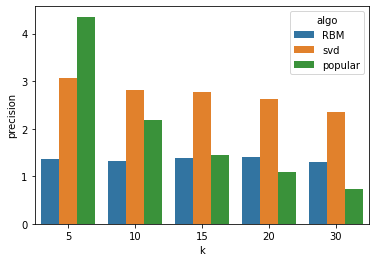

In [11]:
sns.barplot(data=performane_df, x='k', y='precision', hue='algo')

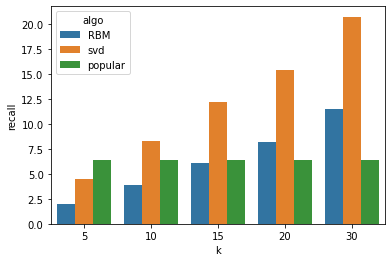

In [12]:
sns.barplot(data=performane_df, x='k', y='recall', hue='algo')

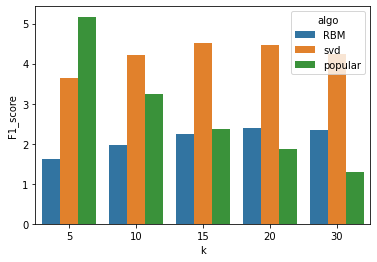

In [13]:
sns.barplot(data=performane_df, x='k', y='F1_score', hue='algo')

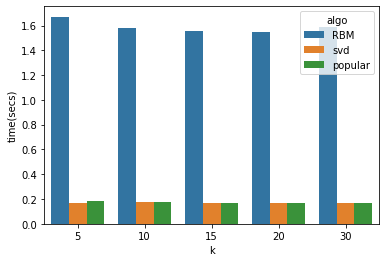

In [14]:
sns.barplot(data=performane_df, x='k', y='time(secs)', hue='algo')

10000 user data run on kernel servers because of the limitations of my local computer,
result are shown below.With 10000 users results are better for rbm model. 

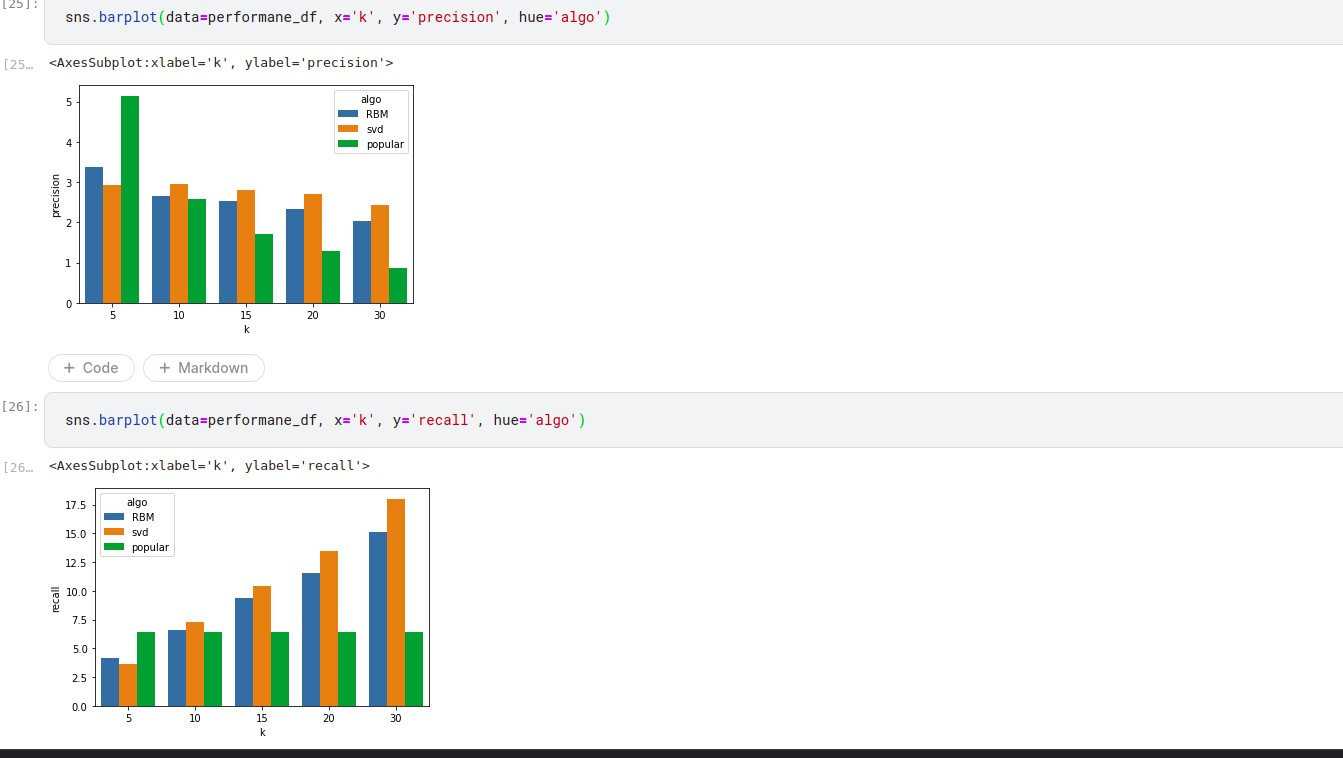

In [15]:
from IPython.display import Image
Image(filename="user_10000.png")